In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision.transforms import Lambda
from tqdm import tqdm
import time

In [2]:
class AutoRec(nn.Module):
    def __init__(self, num_hidden, num_users, dropout=0.05,mode = 'train'):
        super(AutoRec, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_users,num_hidden),
            nn.Sigmoid()
        )
        self.decoder = nn.Linear(num_hidden,num_users)
        self.dropout = nn.Dropout(dropout)
        self.mode = mode

    def forward(self, X):
        hidden = self.dropout(self.encoder(X)) #(b,num_users) ->(b,num_hidden)
        y = self.decoder(hidden) #(b,num_hidden) ->(b,num_users)
        if self.mode=='train':  # Mask the gradient during training
            return y * torch.sign(X) # -1 if x < 0, 0 if x==0, 1 if x > 0. X中未标注的数据为0，用来屏蔽未标注的输入的梯度对模型的影响
        else:
            return y

In [3]:
class InteractionDataset(Dataset):
    def __init__(self, mat,transform=None):
        self.mat = mat
        self.transform = transform

    def __len__(self):
        return self.mat.shape[0]

    def __getitem__(self, idx):
        x = self.mat[idx]
        if self.transform:
            x = self.transform(x)
        return x

In [4]:
def read_data_ml100k():
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv('../../data/ml-100k/u.data', '\t', names=names,engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

def split_data_ml100k(data, num_users, split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time)) # 如果键不在字典里，setdefault将键和默认值添加到字典中，最后返回该键对应的值。这里返回list，通过append将所有相同user的item放到同一个key对应的value里。
            if u not in test_items or test_items[u][-1] < time: # 将最新的item放到test_items
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3])) # 将每个user对应的value 按照时间戳从小到大排序放到train_list
        test_data = [(key, *value) for key, value in test_items.items()] # 将test_items变成list
        train_data = [item for item in train_list if item not in test_data] #将train_list不在test_data里的元素放到train_data
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = np.random.uniform(0, 1, (len(data))) < 1 - test_ratio # 生成(len(data),)大小的bool类型数组 随机test_ratio比例的元素为False，其余为True
        neg_mask = [not x for x in mask] # 生成len(data)长度的bool类型list 元素和mask相反
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1) #0~942 0~1681
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index) # 隐式则为字典 key为user，value为按时间排序的item list
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter


def split_and_load_ml100k(split_mode='random', feedback='explicit',
                          test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_ml100k()
    train_data, test_data = split_data_ml100k(
        data, num_users, split_mode, test_ratio)
    _, _, _, train_inter_mat = load_data_ml100k(train_data, num_users, num_items, feedback)
    _, _, _, test_inter_mat = load_data_ml100k(test_data, num_users, num_items, feedback)
    transform = Lambda(lambda x: torch.tensor(x,dtype=torch.float))
    train_set = InteractionDataset(train_inter_mat,transform)
    test_set = InteractionDataset(test_inter_mat,transform)
    train_iter = DataLoader(train_set, shuffle=True, batch_size=batch_size)
    test_iter = DataLoader(test_set, batch_size=batch_size)
    return num_users, num_items, train_iter, test_iter

num_users, num_items, train_iter, test_iter = split_and_load_ml100k()

C:\Users\12548\AppData\Local\Temp/ipykernel_24884/700341194.py:47: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  data, num_users, num_items = read_data_ml100k()


In [5]:
def evaluate_loss(data_iter, net,loss, device=None):
    """
    输出y为某个值时
    :param data_iter:
    :param net:
    :param device:
    :return:
    """
    with torch.no_grad():
        for x in data_iter:
            net.eval() # 评估模式, 这会关闭dropout
            x = x.to(device)
            y_hat = net(x)
            l = loss(y_hat, x).cpu().item()
            net.train() # 改回训练模式
    return l
def train(net, train_iter, test_iter, optimizer,loss, device, num_epochs,oneHotEncoder=None,scheduler = None):
    net = net.to(device)
    print("training on ", device)
    plt_epoch = []
    plt_train_loss = []
    plt_test_loss = []
    for epoch in range(num_epochs):
        plt_epoch.append(epoch)
        train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        for x in tqdm(train_iter):
            x = x.to(device)
            y_hat = net(x)
            l = loss(y_hat, x)
            optimizer.zero_grad()
            l.backward()
            # grad_clipping(net, 1)
            optimizer.step()
            train_l_sum += l.cpu().item()
            n += x.shape[0] # batch_num
            batch_count += 1
        if scheduler:
            scheduler.step()
        test_loss = evaluate_loss(test_iter, net,loss,device)
        plt_test_loss.append(test_loss)
        plt_train_loss.append(train_l_sum / batch_count)
        print('epoch %d, train_loss %.4f,train_loss %.4f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count,test_loss, time.time() - start))
    plt.plot(plt_epoch, plt_train_loss, color='r', label='train')  # r表示红色
    plt.plot(plt_epoch, plt_test_loss, color='b', label='test')  
    plt.show()

training on  cuda


100%|██████████| 7/7 [00:00<00:00, 31.05it/s]


epoch 1, train_loss 0.4661,train_loss 0.0146, time 0.3 sec


100%|██████████| 7/7 [00:00<00:00, 125.29it/s]


epoch 2, train_loss 0.2868,train_loss 0.0145, time 0.1 sec


100%|██████████| 7/7 [00:00<00:00, 125.37it/s]


epoch 3, train_loss 0.2655,train_loss 0.0130, time 0.1 sec


100%|██████████| 7/7 [00:00<00:00, 127.46it/s]


epoch 4, train_loss 0.2611,train_loss 0.0128, time 0.1 sec


100%|██████████| 7/7 [00:00<00:00, 120.29it/s]


epoch 5, train_loss 0.2556,train_loss 0.0122, time 0.1 sec


100%|██████████| 7/7 [00:00<00:00, 127.42it/s]


epoch 6, train_loss 0.2526,train_loss 0.0121, time 0.1 sec


100%|██████████| 7/7 [00:00<00:00, 122.93it/s]


epoch 7, train_loss 0.2490,train_loss 0.0119, time 0.1 sec


100%|██████████| 7/7 [00:00<00:00, 120.90it/s]


epoch 8, train_loss 0.2434,train_loss 0.0121, time 0.1 sec


100%|██████████| 7/7 [00:00<00:00, 119.16it/s]

epoch 9, train_loss 0.2370,train_loss 0.0118, time 0.1 sec



100%|██████████| 7/7 [00:00<00:00, 116.01it/s]


epoch 10, train_loss 0.2307,train_loss 0.0123, time 0.1 sec


100%|██████████| 7/7 [00:00<00:00, 118.12it/s]


epoch 11, train_loss 0.2272,train_loss 0.0124, time 0.1 sec


100%|██████████| 7/7 [00:00<00:00, 99.67it/s]


epoch 12, train_loss 0.2244,train_loss 0.0126, time 0.1 sec


100%|██████████| 7/7 [00:00<00:00, 127.64it/s]

epoch 13, train_loss 0.2226,train_loss 0.0131, time 0.1 sec



100%|██████████| 7/7 [00:00<00:00, 125.01it/s]


epoch 14, train_loss 0.2211,train_loss 0.0127, time 0.1 sec


100%|██████████| 7/7 [00:00<00:00, 129.18it/s]


epoch 15, train_loss 0.2206,train_loss 0.0135, time 0.1 sec


100%|██████████| 7/7 [00:00<00:00, 116.48it/s]

epoch 16, train_loss 0.2193,train_loss 0.0135, time 0.1 sec



100%|██████████| 7/7 [00:00<00:00, 131.07it/s]


epoch 17, train_loss 0.2197,train_loss 0.0135, time 0.1 sec


100%|██████████| 7/7 [00:00<00:00, 127.05it/s]


epoch 18, train_loss 0.2201,train_loss 0.0131, time 0.1 sec


100%|██████████| 7/7 [00:00<00:00, 118.64it/s]


epoch 19, train_loss 0.2173,train_loss 0.0131, time 0.1 sec


100%|██████████| 7/7 [00:00<00:00, 119.55it/s]


epoch 20, train_loss 0.2168,train_loss 0.0127, time 0.1 sec


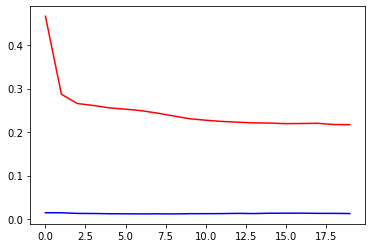

'\n测试1：\nepoch 1, train_loss 0.5147,train_loss 0.0131, time 1.8 sec\nepoch 2, train_loss 0.3148,train_loss 0.0169, time 0.1 sec\nepoch 20, train_loss 0.1679,train_loss 0.0110, time 0.1 sec\n参数：num_hidden=500\n结构：\nself.encoder = nn.Sequential(\n            nn.Linear(num_users,num_hidden),\n            nn.Sigmoid()\n        )\n        self.decoder = nn.Linear(num_hidden,num_users)\n        self.dropout = nn.Dropout(dropout)\n        self.mode = mode\n\n测试2：\nepoch 1, train_loss 0.4730,train_loss 0.0178, time 2.2 sec\nepoch 2, train_loss 0.2741,train_loss 0.0165, time 0.1 sec\nepoch 20, train_loss 0.1423,train_loss 0.0144, time 0.1 sec\n参数：num_hidden=1000\n结构：\n同测试1\n\n测试3：\nepoch 1, train_loss 0.6960,train_loss 0.0304, time 0.1 sec\nepoch 2, train_loss 0.3120,train_loss 0.0203, time 0.1 sec\nepoch 20, train_loss 0.2035,train_loss 0.0181, time 0.1 sec\n参数：num_hidden=200\n结构：\n同测试1\n'

In [7]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))
loss = RMSELoss
net = AutoRec(500,num_users)
optimizer = torch.optim.Adam(net.parameters(), lr=0.002)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epoch = 20
train(net,train_iter,test_iter,optimizer,loss,device,num_epoch)
"""
测试1：
epoch 1, train_loss 0.5147,train_loss 0.0131, time 1.8 sec
epoch 2, train_loss 0.3148,train_loss 0.0169, time 0.1 sec
epoch 20, train_loss 0.1679,train_loss 0.0110, time 0.1 sec
参数：num_hidden=500
结构：
self.encoder = nn.Sequential(
            nn.Linear(num_users,num_hidden),
            nn.Sigmoid()
        )
        self.decoder = nn.Linear(num_hidden,num_users)
        self.dropout = nn.Dropout(dropout)
        self.mode = mode

测试2：
epoch 1, train_loss 0.4730,train_loss 0.0178, time 2.2 sec
epoch 2, train_loss 0.2741,train_loss 0.0165, time 0.1 sec
epoch 20, train_loss 0.1423,train_loss 0.0144, time 0.1 sec
参数：num_hidden=1000
结构：
同测试1

测试3：
epoch 1, train_loss 0.6960,train_loss 0.0304, time 0.1 sec
epoch 2, train_loss 0.3120,train_loss 0.0203, time 0.1 sec
epoch 20, train_loss 0.2035,train_loss 0.0181, time 0.1 sec
参数：num_hidden=200
结构：
同测试1
"""